<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/ordinary_kriging/kriging/ordinary_kriging_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install earthengine-api geemap geopandas geobr rtree pyproj rasterio contextily descartes -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 928.1/928.1 kB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.9 MB/s eta 0:00:00
   

In [2]:
!pip install pykrige -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.6/852.6 kB 12.5 MB/s eta 0:00:00


In [3]:
## Import packages
import rasterio as rio
from rasterio.transform import Affine
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
import contextily as cx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geemap
import json
import seaborn as sns
from shapely.geometry import Point
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [4]:
DEBUG = False #@param {type:"boolean"}
GDRIVE_BASE = "/content/drive" #@param
PROJECT_BASE = f"{GDRIVE_BASE}/MyDrive/amazon_rainforest_files"
# From PROJECT_BASE root
DATASET_PATH = "amazon_sample_data/uc_davis_2023_08_13_kriging_test_random_ungrouped.csv" #@param
# From PROJECT_BASE root
BIOME_PATH = "christian_files/BR_UF_2021.shp" #@param
# From PROJECT_BASE root
OUTPUT_ISOSCAPE_PATH = "amazon_rasters/uc_davis_d18O_cel.tiff" #@param
ISOTOPE_COLUMN_NAME = "d18O_cel" #@param

In [5]:
# Access data stored on Google Drive
if GDRIVE_BASE:
    from google.colab import drive
    drive.mount(GDRIVE_BASE)

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

Mounted at /content/drive


In [52]:
# Function to convert result to raster file
def export_kriging_raster(isotope_values, variances, isoscape_long_values, isoscape_lat_values, proj, filename):
    '''Export and save a kernel density raster.
    isotope_values: matrix of values from Kriging interpolation for coordinates
      in isoscape_long_values and isoscape_lat_values
    variances: matrix of variances form Kriging interpolation for coordinates
      in isoscape_long_values and isoscape_lat_values
    isoscape_long_values: the sampled longitude points of the target isoscape
    proj: Projection configuration of target isoscape
    filename: Filename to write the isoscape raster to.
    '''

    min_long = min(isoscape_long_values)
    max_long = max(isoscape_long_values)
    min_lat = min(isoscape_lat_values)
    max_lat = max(isoscape_lat_values)
    # Get resolution
    long_res = (max_long - min_long) / len(isoscape_long_values)
    lat_res = (max_lat - min_lat) / len(isoscape_lat_values)

    # Set transform
    transform = Affine.translation(min_long - long_res / 2, min_lat - lat_res / 2) * Affine.scale(long_res, lat_res)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = isotope_values.shape[0],
            width = isotope_values.shape[1],
            count = 2,
            dtype = isotope_values.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(isotope_values, 1)
            new_dataset.write(variances, 2)

In [7]:
# Load coordinates and values from dataset path.
df = pd.read_csv(f"{PROJECT_BASE}/{DATASET_PATH}").dropna(subset=['lat', 'long', ISOTOPE_COLUMN_NAME])
long = df['long'].values
lat = df['lat'].values
isotope_values = df[ISOTOPE_COLUMN_NAME].values

In [8]:
# Load Amazon geometry dataset that'll be used to mask isoscape in expected shape.
amazon_biome_path = f"{PROJECT_BASE}/{BIOME_PATH}"
gdf_amazon = gpd.read_file(amazon_biome_path)

/usr/local/lib/python3.10/dist-packages/geopandas/array.py:93: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


In [9]:
# RasterIO projection configuration used to create raster from isoscape from interpolation.
proj = "+proj=aea +lat_1=34 +lat_2=40.5 +lat_0=0 +lon_0=-120 +x_0=0 +y_0=-4000000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs "

In [53]:
def create_isoscape_ordinary_kriging(
    gdf_amazon: gpd.GeoDataFrame,
    long: list,
    lat: list,
    isotope_values: list,
    proj: str,
    out_filename: str
):
  '''
  Creates an isoscape for a gdf_amazon with values projected from fitted
  Ordinary Kriging model on the coordinates x, y and z
  using the configuration proj for the raster.
  '''

  ok = OrdinaryKriging(
      long,
      lat,
      isotope_values,
      variogram_model="linear",
      verbose=False,
      enable_plotting=True,
      enable_statistics=True,
      coordinates_type='geographic',
      pseudo_inv=True # this leads to more numerical stability and redundant
                      # points are averaged. This prevents singular matrix
                      # errors which happens frequently with variance isoscape
                      # in this method.
  )

  min_long, min_lat, max_long, max_lat = gdf_amazon.total_bounds
  isoscape_long_values = np.linspace(min_long, max_long, 235)
  isoscape_lat_values  = np.linspace(min_lat, max_lat, 234)
  # Predict the isotope values on the range of lattitude and longitude values
  # within the gdf_amazon geomtry.
  isotope_values, variances  = ok.execute("grid", isoscape_long_values, isoscape_lat_values)
  ok.print_statistics()

  export_kriging_raster(isotope_values, variances, isoscape_long_values, isoscape_lat_values,
                        proj, out_filename)

In [54]:
def display_isoscape(filename, gdf_amazon):
  '''
  Given a filename to a RasterIO file containing an isoscape raster,
  display the isoscape masked by the gdf_amazon geomtry.
  '''
  raster_pk = rasterio.open(filename)

  # Mean Isotope Isoscape Band Image
  out_image_pk, out_transform_pk = rio.mask.mask(raster_pk, gdf_amazon.geometry.values, crop = True, indexes=1)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 20))
  means_raster = show(out_image_pk, ax = ax1, transform = out_transform_pk, cmap = "RdYlGn")
  means_im = means_raster.get_images()[0]
  fig.colorbar(means_im, ax=ax1, shrink=0.3)

  ax1.invert_yaxis()
  ax1.set_title("Mean Isotope Isoscape Band")

  # Variance Isotope Isoscape Band Image
  out_image_pk, out_transform_pk = rio.mask.mask(raster_pk, gdf_amazon.geometry.values, crop = True, indexes=2)

  vars_raster = show(out_image_pk, ax = ax2, transform = out_transform_pk, cmap = "RdYlGn")
  vars_im = vars_raster.get_images()[0]
  fig.colorbar(vars_im, ax=ax2, shrink=0.3)

  plt.gca().invert_yaxis()
  ax2.set_title("Variance Isotope Isoscape Band")
  plt.show()

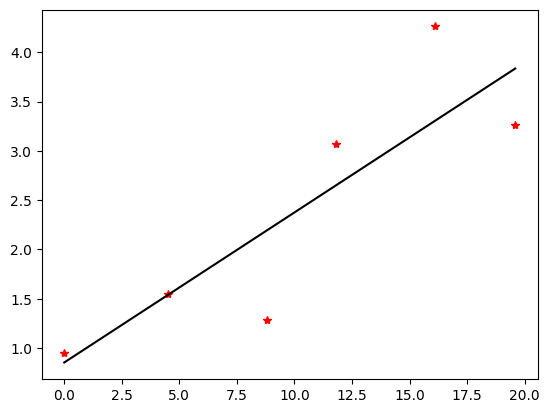

Q1 = 0.05788967590036385
Q2 = 1.5510874754187276
cR = 2.3737471972497253


In [55]:
create_isoscape_ordinary_kriging(gdf_amazon, long, lat, isotope_values, proj, f"{PROJECT_BASE}/{OUTPUT_ISOSCAPE_PATH}")

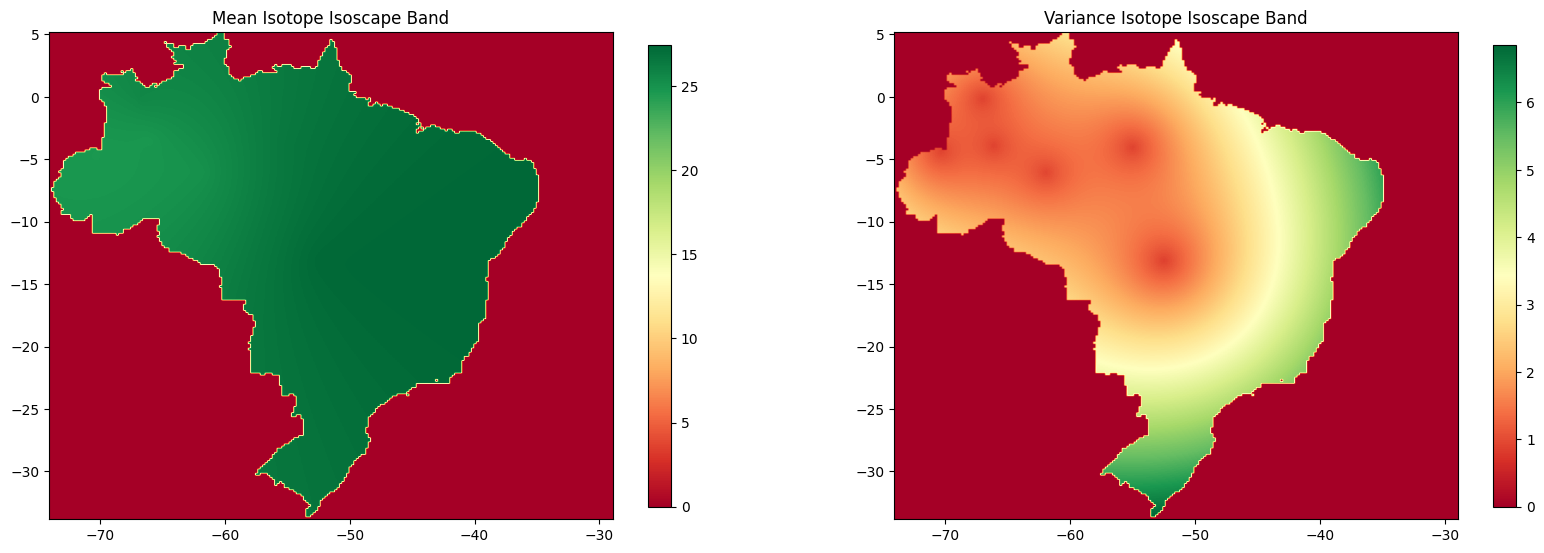

In [56]:
filename = f"{PROJECT_BASE}/{OUTPUT_ISOSCAPE_PATH}"
display_isoscape(filename, gdf_amazon)